## Build a Basic Chatbot

In [76]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [77]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]

In [78]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [79]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [80]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021E28287110>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021E285A07D0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [81]:
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021E280390F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021E28039A70>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [82]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [83]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

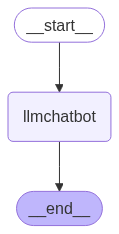

In [84]:
#visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [85]:
response=graph.invoke({"messages":"Hi"})

In [86]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [87]:
for event in graph.stream({"messages": [{"role": "user", "content": "Hello, how are you?"}]}):
    for val in event.values():
        print(val["messages"][-1].content)

I'm just a language model, I don't have feelings or emotions like humans do, so I don't have a emotional state. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?


# Chatbot with External Tools

> **Purpose**: This chatbot integrates live tools (e.g., for news updates, weather, or search) with the LLM to provide **real-time information** the model isn’t trained on or has outdated knowledge about.

---

### 🔄 Flow Diagram

Start Node
↓
LLM + Binding Tool Node
↓
Tool Call (e.g., Web Search / News API)
↓
End


> In cases where the tool call isn't needed (based on the LLM's response logic):

Start Node
↓
LLM + Binding Tool Node
↓
End
---

### ✅ Explanation

- **Start Node**: Receives the user input.
- **LLM + Binding Tool Node**: Uses logic to decide if a tool (external data source) is required.
- **Tool Call**: Fetches fresh/live information (e.g., news, stock prices, real-time facts).
- **End**: Returns the final response to the user—either directly from the LLM or combined with external tool output.

---

### 🧩 Use Cases

- Real-time news updates 📰  
- Weather forecasts 🌦️  
- Sports scores ⚽  
- Web search 🔍  
- Financial data 💹  

---

### ⚙️ Powered by:

- `langgraph` for state-based logic flow  
- `langchain` or equivalent for tool bindings  
- External APIs for live data  




In [88]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c

In [89]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [90]:

tools=[tool,multiply]

In [91]:
llm_with_tool=llm.bind_tools(tools)

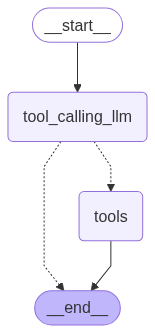

In [92]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [94]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2025/06/20/mira-muratis-thinking-machines-lab-closes-on-2b-at-10b-valuation/", "title": "Mira Murati’s Thinking Machines Lab closes on $2B at $10B valuation - TechCrunch", "score": 0.6972179, "published_date": "Fri, 20 Jun 2025 21:59:33 GMT", "content": "Enterprise \\n### Workhelix taps years of research to help enterprises figure out where to apply AI\\n\\n       Rebecca Szkutak\\n\\n Feb 27, 2025\\n\\nLatest in AI\\n------------\\n\\nSee More\\n\\n   \\nImage 9\\n\\nIn Brief \\n### Mira Murati’s Thinking Machines Lab closes on $2B at $10B valuation\\n\\n       Rebecca Bellan\\n\\n 11 seconds ago\\n\\n   \\nImage 10: Cluely founder Roy Lee party invitation video\\n\\nAI \\n### Cluely, a startup that helps ‘cheat on everything,’ raises $15M from a16z\\n\\n       Marina Temkin\\n\\n 53 minutes ago", "raw_content": null}, {"url": "https://www.lightreading.co

In [95]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5bbb9fc22)
 Call ID: 5bbb9fc22
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2025/06/20/mira-muratis-thinking-machines-lab-closes-on-2b-at-10b-valuation/", "title": "Mira Murati’s Thinking Machines Lab closes on $2B at $10B valuation - TechCrunch", "score": 0.6972179, "published_date": "Fri, 20 Jun 2025 21:59:33 GMT", "content": "Enterprise \n### Workhelix taps years of research to help enterprises figure out where to apply AI\n\n       Rebecca Szkutak\n\n Feb 27, 2025\n\nLatest in AI\n------

In [96]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (ghmhvk4ax)
 Call ID: ghmhvk4ax
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [97]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (2pw1mwqhp)
 Call ID: 2pw1mwqhp
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2025/06/20/mira-muratis-thinking-machines-lab-closes-on-2b-at-10b-valuation/", "title": "Mira Murati’s Thinking Machines Lab closes on $2B at $10B valuation - TechCrunch", "score": 0.6972179, "published_date": "Fri, 20 Jun 2025 21:59:33 GMT", "content": "Enterprise \n### Workhelix taps years of research to help enterprises figure out where to apply AI\n\n       Rebecca Szkutak\n\n Feb 27, 20

# ReACT Agent Architecture

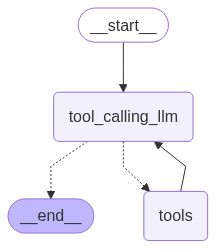

In [98]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7r1my08gz)
 Call ID: 7r1my08gz
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.investopedia.com/amazon-s-ceo-tells-staff-ai-could-lead-to-a-smaller-corporate-workforce-11756555", "title": "Amazon's CEO Tells Staff AI Could Lead to a Smaller Corporate Workforce - Investopedia", "score": 0.5996498, "published_date": "Tue, 17 Jun 2025 21:29:00 GMT", "content": "conference.:max_bytes(150000):strip_icc():format(webp)/GettyImages-2215577822-47a75431e5254defb1dd57019a2c8389.jpg) Google Buyouts Could Point 

# Adding Memory In Agentic Graph

In [100]:
response=graph.invoke({"messages":"Hello my name is Kansihk Jagya"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Kansihk Jagya
================================== Ai Message ==================================

Nice to meet you, Kansihk Jagya! I'm here to help you with any questions or tasks you may have. What brings you here today?


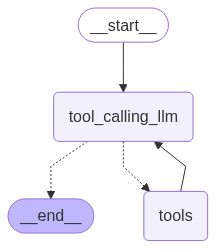

In [101]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [103]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Kanishk"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='bc0a919b-48fd-4ca2-86ee-f5a164d3477f'),
  AIMessage(content='Nice to meet you, Krish! What brings you here today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 2193, 'total_tokens': 2207, 'completion_time': 0.013453135, 'prompt_time': 0.502190983, 'queue_time': 1.678029471, 'total_time': 0.515644118}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--7f81623a-14cd-4855-a21c-aca6f3d3f2c4-0', usage_metadata={'input_tokens': 2193, 'output_tokens': 14, 'total_tokens': 2207}),
  HumanMessage(content='Hi my name is Kanishk', additional_kwargs={}, response_metadata={}, id='197d858e-6473-41ab-8702-0f4d24b1f350'),
  AIMessage(content='Nice to meet you, Kanishk! How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens'

In [104]:
response['messages'][-1].content

'Nice to meet you, Kanishk! How can I help you today?'

In [105]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Kanishk!


In [106]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

Yes, I remember that your name is Kanishk!


# Streaming

In [107]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [108]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

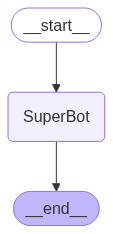

In [109]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [111]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Kanishk And I like Football"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='cdeb1a74-42a1-4685-8004-c81c2b710e53'),
  AIMessage(content="Nice to meet you, Krish! It's great to hear that you like cricket! What's your favorite team or player? Are you a fan of Test cricket, One-Day Internationals (ODIs), or Twenty20 (T20)?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 20, 'total_tokens': 70, 'completion_time': 0.034201093, 'prompt_time': 0.002710681, 'queue_time': 0.274277858, 'total_time': 0.036911774}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--e3f70bfa-2cf6-4d25-8054-b6326b9bf962-0', usage_metadata={'input_tokens': 20, 'output_tokens': 50, 'total_tokens': 70}),
  HumanMessage(content='Hi,My name is Kanishk And I like Football', additional_kwargs={}, response_metadata={}, id='07105fb5-de35-402f-b868-e98bf

In [112]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Kanishk And I like Football"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hi Kanishk! Nice to meet you! Football is a great passion to have! Which team or league do you support? Are you a fan of a particular player or a specific style of play?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.038975715, 'prompt_time': 0.003242842, 'queue_time': 0.26977989799999996, 'total_time': 0.042218557}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--0f4baaa9-8aad-4585-994c-35eb7e25e28b-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64})]}}


In [113]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Kanishk And I like Football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Kanishk And I like Football', additional_kwargs={}, response_metadata={}, id='ef51b419-6a88-4f64-aee9-056cf6da42a1'), AIMessage(content='Hi Kanishk! Nice to meet you! Football is a great passion to have! Which team or league do you support? Are you a fan of a particular player or a specific style of play?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.038975715, 'prompt_time': 0.003242842, 'queue_time': 0.26977989799999996, 'total_time': 0.042218557}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--0f4baaa9-8aad-4585-994c-35eb7e25e28b-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64}), HumanMessage(content='Hi,My name is Kanishk And I like Football', additional_kwargs={}, response_metadata={}, id='3d2574b0-e5c2-44c6-969f-ec2ff6e43a1c'

In [114]:
for chunk in graph_builder.stream({'messages':"I also like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Kanishk And I like Football', additional_kwargs={}, response_metadata={}, id='ef51b419-6a88-4f64-aee9-056cf6da42a1'), AIMessage(content='Hi Kanishk! Nice to meet you! Football is a great passion to have! Which team or league do you support? Are you a fan of a particular player or a specific style of play?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.038975715, 'prompt_time': 0.003242842, 'queue_time': 0.26977989799999996, 'total_time': 0.042218557}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--0f4baaa9-8aad-4585-994c-35eb7e25e28b-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64}), HumanMessage(content='Hi,My name is Kanishk And I like Football', additional_kwargs={}, response_metadata={}, id='3d2574b0-e5c2-44c6-969f-ec2ff6e43a1c'

In [115]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Kanishk and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Kanishk and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '0771c756-b3e0-4ade-9943-23d81948fbf5', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Kanishk and I like to play cricket', additional_kwargs={}, response_metadata={}, id='c2a86bfa-cc6a-4b3d-99a5-5be67af8160a')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '05745f17-d2f1-4ddd-9a77-54f3bf7f048e', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:b77c13af-bb92-0cb9-49bf-4f52df1c37b6'}, 'parent_ids': ['0771c756-b3e0-4ade-9943-23d81948fbf5']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Kanishk and I like 